# Timeseries \& Correlation Matrix Generator 

## Single-Factor & Multi-Factor Models 

### Yelibi & Gebbie
- The single-factor model follows the technique of Giada & Marsili who use the Noh Ansatz to provide the proposed structure for a correlation matrix of a set of time series characterised by a clustering structure.
- The correlated time series are generated using the Noh Anzats stochastic process model for clustering purposes:
$\xi_i(d) = \frac{\sqrt{g_{s_i}}\eta_i(d)+\epsilon_i(d)}{\sqrt{1+g_{s_i}}}$, where there are $s$ clusters, $i$ stocks and $d$ observations of each stock price time series.
- A special case of the Tumminello *et al* method is employed here where $\alpha = 1-\sum \beta$ to generate a multi-factor version of the model, where $\alpha$ and $\beta$ are the weights assigned to the stocks' individual effects $\epsilon$ and the hierarchical factors' effects $\eta$ on the price return process, respectively. $\alpha$ modulates the signal-to-noise ratio, and the $\beta$s are chosen such that $\sum \beta \in [0,1]$ and such that stocks belonging to a specific hierarchy are more correlated to that hierarchy's factor effect. The correlation matrix is organised into nested clusters. The hierarchical factor effect is sequentially added to the stock return signal, meaning that each stock inheriting these factor effects will be correlated with others included in the same cluster, and that the factor effects are inherited by lower hierarchies from higher ones. 

In [1]:
import numpy as np

def single_factor_model(N, C, L, gs, model='normal'):
    """
    Generates a dataset using the single-factor model proposed by Giada & Marsili using the Noh Ansatz and its correlation matrix.
    
    N: number of observations/stocks
    C: number of clusters 
    L: length of timeseries
    gs: coupling parameter/strength of relationship intra-cluster. This is consistent across clusters.
    model: normal distribution used to generate cluster- and stock-specific noise/random effects (IID random variables)

    :return: the data set of timeseries, the cluster membership key, and the correlation matrix.
    """
    key = np.sort(np.random.choice(range(C), N))
    gsvector = gs * np.ones(N)

    if model == 'normal':
        eta = np.random.normal(size=(C, L))
        epsilon = np.random.normal(size=(N, L))

    timeseries = (np.sqrt(gsvector).reshape(-1, 1) * eta[key] + epsilon) / np.sqrt(1 + gsvector).reshape(-1, 1)

    # Calculate the correlation matrix
    correlation_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            correlation_matrix[i, j] = (gsvector[i] * (key[i] == key[j]) + (i == j)) / (1 + gsvector[i])

    return timeseries, key, correlation_matrix

def multi_factor_model_fixed_gs(N, C, L, gs, F, factor_weights=None, model='normal'):
    """
    Generates a dataset using the Yelibi & Gebbie multi-factor model and its correlation matrix.
    A special version of the Tumminello et al. general nested linear model.
    
    N: number of observations/stocks
    C: number of clusters 
    L: length of timeseries
    gs: coupling parameter/strength of relationship intra-cluster. This is consistent across clusters.
    This makes for easier interpretability and a simplified process (Yelibi & Gebbie, 2021)
    factor_weights: set to None. Equal weights given to each factor 
    F: number of factors
    model: normal distribution used to generate cluster- and stock-specific noise (IID random variables)
    
    *Note*: If N = F, this is equivalent to the one-factor model, i.e. there is one factor affecting each stock with equal strength.
    
    :return: the data set of timeseries, the cluster membership key, and the correlation matrix.
    """
    
    # Change key to limit its values to range(F)
    F = int(F)
    if not isinstance(F, int) or F <= 0:
        raise ValueError("F should be a positive integer.")
        
    key = np.sort(np.random.choice(range(F), N))
    
    if factor_weights is None:
        factor_weights = np.ones(F) / F
    
    print(gs)

    v = np.zeros((N, F))
    for i in range(N):
        v[i, key[i]] = gs

    if model == 'normal':
        eta = np.random.normal(size=(F, L))
        epsilon = np.random.normal(size=(N, L))
    
    timeseries = (v.dot(eta * factor_weights.reshape(-1, 1)) + epsilon) / np.sqrt(1 + np.linalg.norm(v, axis=1).reshape(-1, 1)**2)

    # Calculate the correlation matrix
    correlation_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            correlation_matrix[i, j] = (v[i, key[i]] * (key[i] == key[j]) + (i == j)) / (1 + v[i, key[i]])

    return timeseries, key, correlation_matrix

def multi_factor_model(N, C, L, F, gs_range=None, factor_weights=None, model='normal'):
    """
    Generates a dataset using the Yelibi & Gebbie multi-factor model and its correlation matrix.
    This is a simplified version of the more general Tumminello et al. nested multi-factor correlated stochastic time series generation method.
    
    N: number of observations/stocks
    C: number of clusters 
    L: length of timeseries
    F: number of factors 
    gs: coupling parameter/strength of relationship intra-cluster. This is NOT consistent across clusters, but rather is randomly generated within a range between 0.1 and 0.3.
    factor_weights: set to None. Equal weights given to each factor 
    model: normal distribution used to generate cluster- and stock-specific noise 
    
    *Note*: If N = F, this is equivalent to the one-factor model 
    
    :return: the data set of timeseries, the cluster membership key, and the correlation matrix.
    """
    # Default gs range
    if gs_range is None:
        gs_range = (0.1, 0.3)
    
    F = int(F)

    key = np.sort(np.random.choice(range(C), N))

    if factor_weights is None:
        factor_weights = np.ones(F) / F

    # Introducing variation in gs for each cluster
    gs_values = np.random.uniform(gs_range[0], gs_range[1], C)
    print(gs_values)

    v = np.zeros((N, F))
    for i in range(N):
        v[i, :] = gs_values[key[i]]

    if model == 'normal':
        eta = np.random.normal(size=(F, L))
        epsilon = np.random.normal(size=(N, L))
    
    timeseries = (v.dot(eta * factor_weights.reshape(-1, 1)) + epsilon) / np.sqrt(1 + np.linalg.norm(v, axis=1).reshape(-1, 1)**2)

    # Calculate the correlation matrix
    correlation_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            correlation_matrix[i, j] = (gs_values[key[i]] * (key[i] == key[j]) + (i == j)) / (1 + gs_values[key[i]])

    return timeseries, key, correlation_matrix

# Example usage
# N, C, L, gs, F = 1000, 5, 1000, 0.8, 5
# data_single, key_single, corr_single = single_factor_model(N, C, L, gs)
# data_multi, key_multi, corr_multi = multi_factor_model(N, C, L, F)


## Single-Factor Model with Fixed Coupling Parameter g per Cluster and No Variance 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Using the single-factor model...
N, C, L, gs, F = 3000, 10, 60, 0.5, 1
#ret, key, correlation_matrix = onefactorwithvar_explicative(cluster_size, clusters_number, length, coupling_parameter)
ret, key, correlation_matrix = single_factor_model(N, C, L, gs)


### Visualisation

<Figure size 432x288 with 0 Axes>

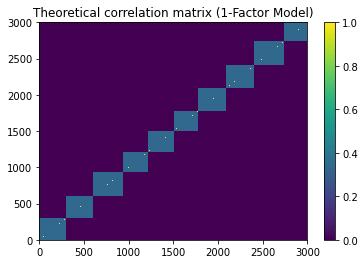

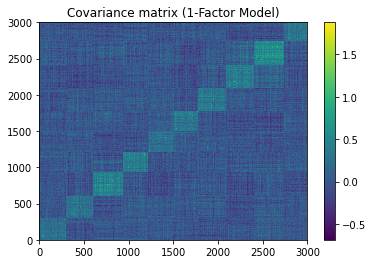

<Figure size 432x288 with 0 Axes>

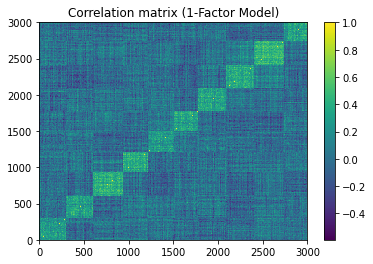

<Figure size 432x288 with 0 Axes>

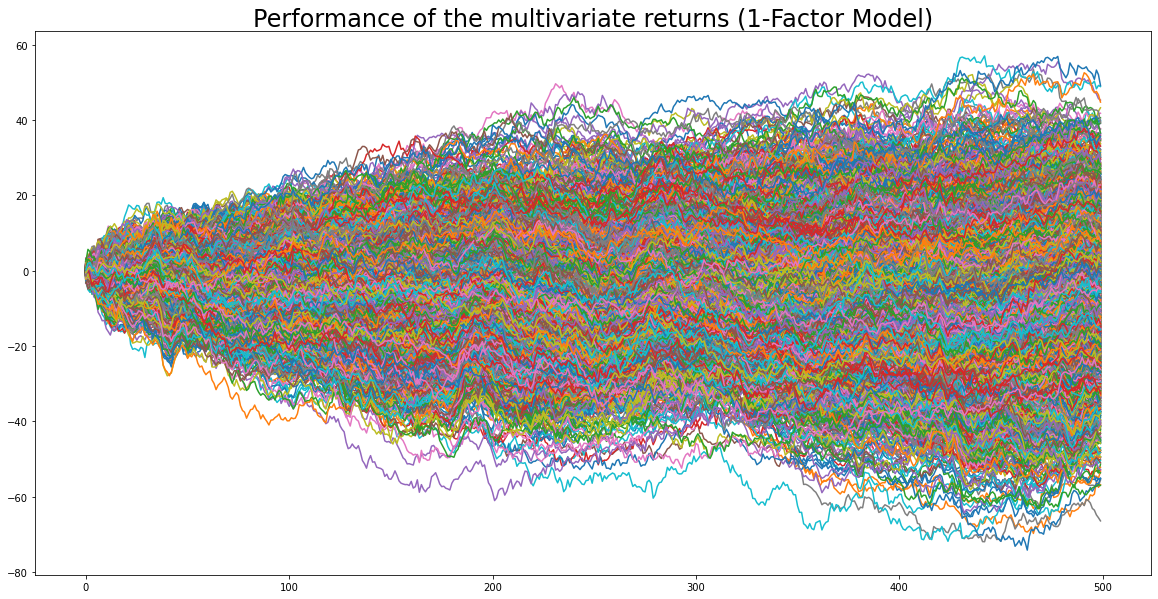

<Figure size 432x288 with 0 Axes>

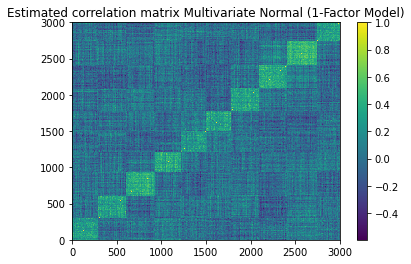

<Figure size 432x288 with 0 Axes>

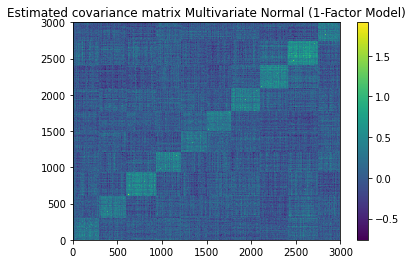

<Figure size 432x288 with 0 Axes>

In [3]:
fig = plt.gcf()
# Correlation Matrix from Literature
plt.figure()
plt.pcolormesh(correlation_matrix)
plt.colorbar()
plt.title('Theoretical correlation matrix (1-Factor Model)')
plt.show()
fig.savefig('theoretical_covariance_1_factor.png')

# Calculated Classical/True Covariance Matrix 
covar = np.cov(ret)

plt.figure()
plt.pcolormesh(covar)
plt.colorbar()
plt.title('Covariance matrix (1-Factor Model)')
plt.show()
plt.savefig('true_covariance_1_factor.png')

# Calculated Classical/True Covariance Matrix 
correl = np.corrcoef(ret)

plt.figure()
plt.pcolormesh(correl)
plt.colorbar()
plt.title('Correlation matrix (1-Factor Model)')
plt.show()
plt.savefig('true_correlation_1_factor.png')

# sample returns from the covariance matrices
alphas_returns = np.random.multivariate_normal(np.zeros(N), cov=covar, size=500).T

plt.figure(figsize=(20, 10))
for i in range(N):
    plt.plot(range(500), alphas_returns.cumsum(axis=1)[i])
plt.title('Performance of the multivariate returns (1-Factor Model)', fontsize=24)
plt.show()
plt.savefig('cumul_multivariate_1_factor.png')

# estimate the correlations and covariance
estimate_correl = np.corrcoef(alphas_returns)
estimate_covar = np.cov(alphas_returns)

plt.figure()
plt.pcolormesh(estimate_correl)
plt.colorbar()
plt.title('Estimated correlation matrix Multivariate Normal (1-Factor Model)')
plt.show()
plt.savefig('estim_cor_multivar_1_factor.png')

plt.figure()
plt.pcolormesh(estimate_covar)
plt.colorbar()
plt.title('Estimated covariance matrix Multivariate Normal (1-Factor Model)')
plt.show()
plt.savefig('estim_cov_multivar_1_factor.png')

### An MST

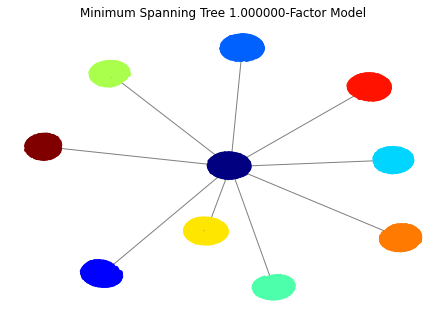

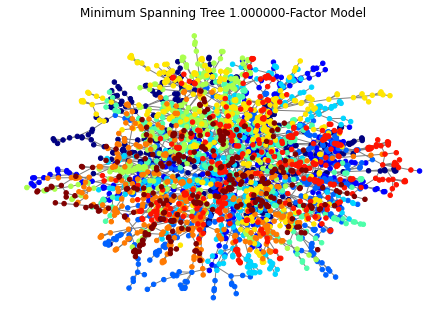

In [4]:
import networkx as nx

# Calculate distance from correlation
def correlation_to_distance(correlation_matrix):
    #distance_matrix = np.sqrt(2.0 * (1.0 - correlation_matrix))
    distance_matrix = 1.0 - correlation_matrix 
    return distance_matrix

# Generate MST from the distance matrix
def generate_mst(distance_matrix):
    G = nx.Graph()
    for i in range(distance_matrix.shape[0]):
        for j in range(i+1, distance_matrix.shape[1]):
            G.add_edge(i, j, weight=distance_matrix[i, j])
    mst = nx.minimum_spanning_tree(G)
    return mst

# Plot the MST with different cluster colors
def plot_mst(mst, key):
    pos = nx.spring_layout(mst)  # position layout for better visualization
    colors = [plt.cm.jet(float(i)/max(key)) for i in key]  # Using the 'jet' colormap for differentiation
    nx.draw(mst, pos, node_color=colors, with_labels=False, node_size=20, edge_color="grey")
    plt.title("Minimum Spanning Tree %f-Factor Model" %F)
    plt.show()

# Generate the distance matrix and MST
distance_matrix = correlation_to_distance(correlation_matrix)
mst = generate_mst(distance_matrix)

# Plot the MST
plot_mst(mst, key)

# Generate the distance matrix and MST for the estimated correlation matrix 
dist_matrix_estimate_correl = correlation_to_distance(correl)
mst_estimate_correl = generate_mst(dist_matrix_estimate_correl)
plot_mst(mst_estimate_correl, key)

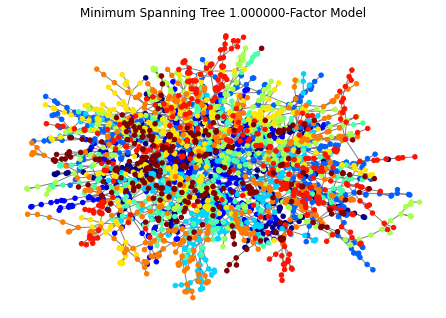

In [5]:
# Generate the distance matrix and MST
distance_matrix = correlation_to_distance(estimate_correl)
mst = generate_mst(distance_matrix)

# Plot the MST
plot_mst(mst, key)

## Multifactor Model with Varying Factor Weights and Fixed Coupling Parameter

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_factor_weights(F):
    """Generate random factor weights that sum to one."""
    weights = np.random.random(F)
    normalized_weights = weights / np.sum(weights)
    return normalized_weights

# Parameters
N = 500  # Number of time series
C = 12  # Number of clusters
L = 1000  # Length of each time series
gs = 0.5  # Some positive value for gs - not necessary for the moment since varying this coupling parameter per cluster
F = 10  # Number of factors

# Generate random factor weights
factor_weights = generate_random_factor_weights(F)
print(factor_weights)
# Get the time series, cluster membership, and correlation matrix
timeseries, key, correlation_matrix = multi_factor_model_fixed_gs(N, C, L, gs, F, factor_weights=factor_weights, model='normal')

# Plotting the first few time series for visualization
# plt.figure(figsize=(20, 10))
# for i in range(10):  # Plotting the first 10 time series for clarity
#     plt.plot(timeseries[i], label=f'Series {i}, Factor {key[i]}')
    
# plt.title('First 10 Time Series from the Multi-factor Model')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()


[0.13801447 0.10228006 0.13785054 0.1125183  0.10776963 0.02863475
 0.15636744 0.01933146 0.08168553 0.11554784]
0.5


### Visualisation

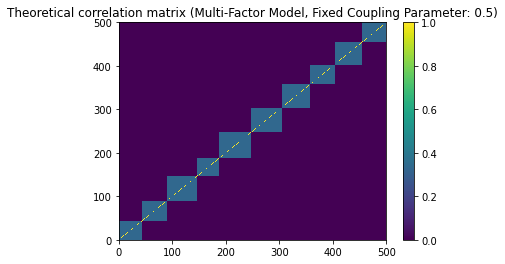

<Figure size 432x288 with 0 Axes>

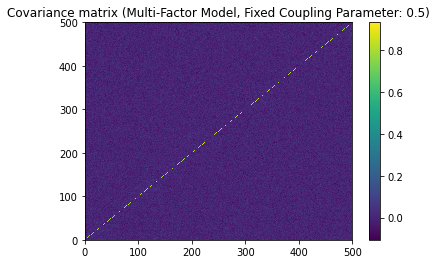

<Figure size 432x288 with 0 Axes>

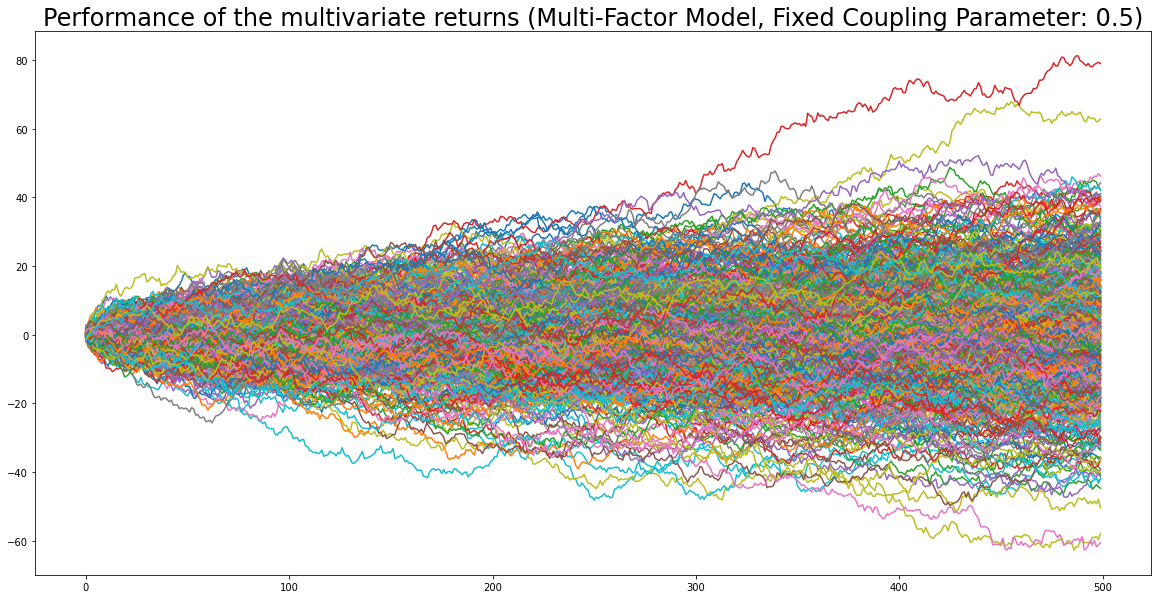

<Figure size 432x288 with 0 Axes>

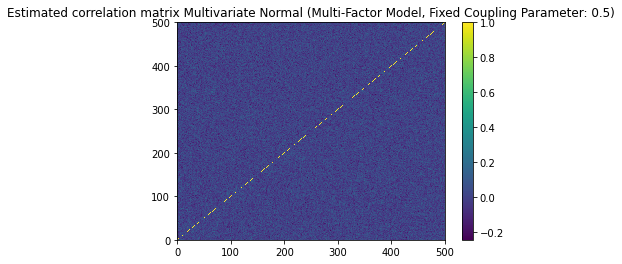

<Figure size 432x288 with 0 Axes>

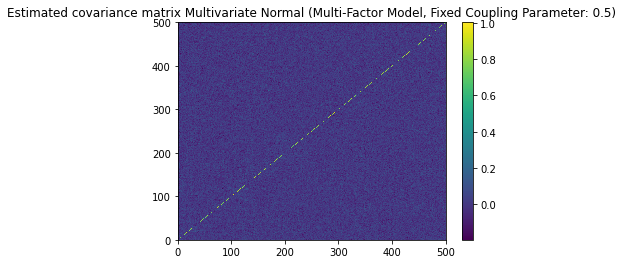

<Figure size 432x288 with 0 Axes>

In [7]:
# Using the explicative factor model...
# cluster_size, clusters_number, length, coupling_parameter = [10, 100, 2000, .99]
# N = cluster_size * clusters_number
# ret, alpha, stds = onefactorwithvar_explicative(cluster_size, clusters_number, length, coupling_parameter, factor_weights)

# Correlation Matrix from Literature
plt.figure()
plt.pcolormesh(correlation_matrix)
plt.colorbar()
plt.title('Theoretical correlation matrix (Multi-Factor Model, Fixed Coupling Parameter: %0.1f)' %gs)
plt.show()
plt.savefig('theoretical_covariance_explicative_factor.png')
covar = np.cov(timeseries)

# True Covariance Matrix
plt.figure()
plt.pcolormesh(covar)
plt.colorbar()
plt.title('Covariance matrix (Multi-Factor Model, Fixed Coupling Parameter: %0.1f)' %gs)
plt.show()
plt.savefig('true_covariance_explicative_factor.png')

# sample returns from the covariance matrices
alphas_returns = np.random.multivariate_normal(np.zeros(N), cov=covar, size=500).T

plt.figure(figsize=(20, 10))
for i in range(N):
    plt.plot(range(500), alphas_returns.cumsum(axis=1)[i])
plt.title('Performance of the multivariate returns (Multi-Factor Model, Fixed Coupling Parameter: %0.1f)' %gs, fontsize=24)
plt.show()
plt.savefig('cumul_multivariate_explicative_factor.png')

# estimate the correlations and covariance
estimate_correl = np.corrcoef(alphas_returns)
estimate_covar = np.cov(alphas_returns)

plt.figure()
plt.pcolormesh(estimate_correl)
plt.colorbar()
plt.title('Estimated correlation matrix Multivariate Normal (Multi-Factor Model, Fixed Coupling Parameter: %0.1f)' %gs)
plt.show()
plt.savefig('estim_cor_multivar_explicative_factor.png')

plt.figure()
plt.pcolormesh(estimate_covar)
plt.colorbar()
plt.title('Estimated covariance matrix Multivariate Normal (Multi-Factor Model, Fixed Coupling Parameter: %0.1f)' %gs)
plt.show()
plt.savefig('estim_cov_multivar_explicative_factor.png')

### An MST

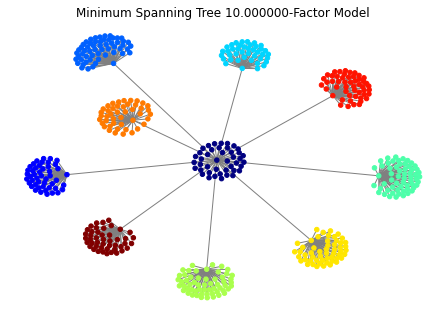

In [8]:
# Generate the distance matrix and MST
distance_matrix = correlation_to_distance(correlation_matrix)
mst = generate_mst(distance_matrix)

# Plot the MST
plot_mst(mst, key)

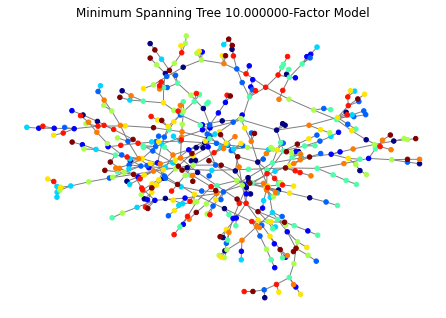

In [9]:
# Generate the distance matrix and MST
distance_matrix = correlation_to_distance(estimate_correl)
mst = generate_mst(distance_matrix)

# Plot the MST
plot_mst(mst, key)

## Multifactor Model with Varying Factor Weights and Varying Coupling Parameter

In [10]:
# Parameters
N = 500  # Number of time series
C = 12  # Number of clusters
L = 1000  # Length of each time series
# gs = 0.3  # Some positive value for gs - not necessary for the moment since varying this coupling parameter per cluster
F = 10  # Number of factors

# Generate random factor weights
factor_weights = generate_random_factor_weights(F)

# Get the time series, cluster membership, and correlation matrix
timeseries, key, correlation_matrix = multi_factor_model(N, C, L, F, factor_weights=factor_weights)

[0.17895818 0.29112865 0.12002498 0.23865264 0.20265971 0.25702714
 0.12684281 0.27419811 0.2752311  0.1626823  0.18576785 0.14838314]


### Visualisation

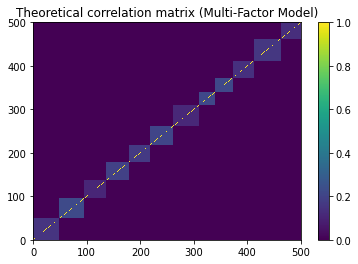

<Figure size 432x288 with 0 Axes>

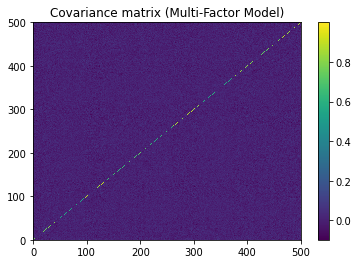

<Figure size 432x288 with 0 Axes>

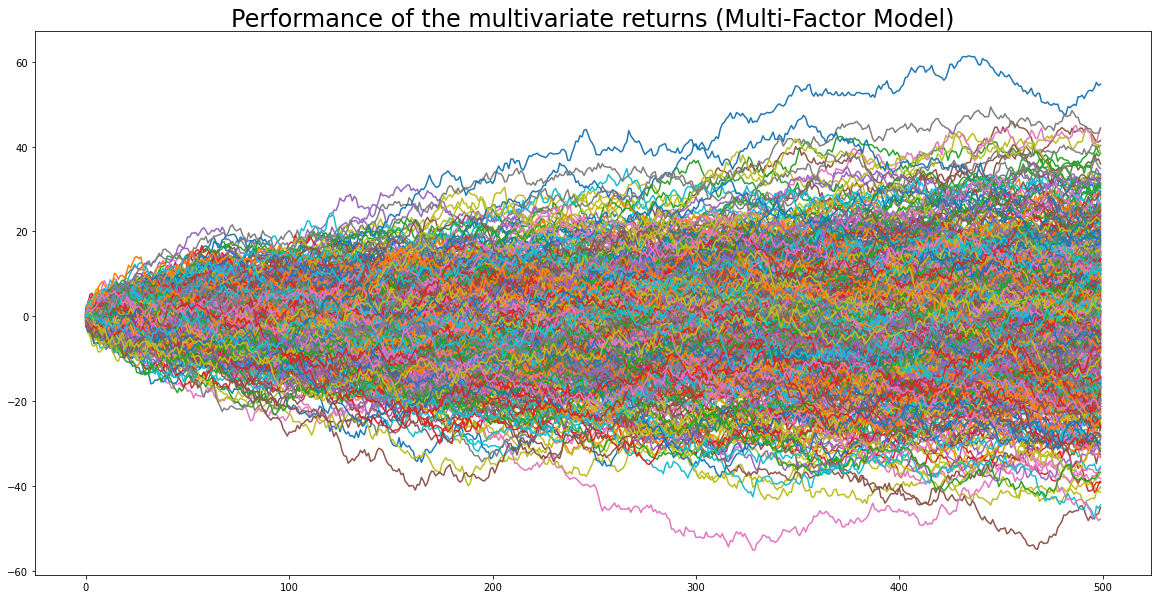

<Figure size 432x288 with 0 Axes>

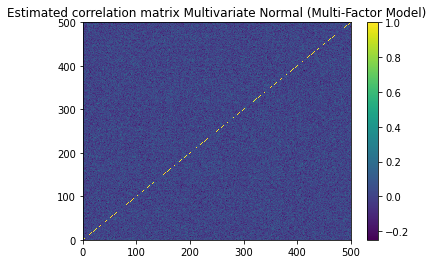

<Figure size 432x288 with 0 Axes>

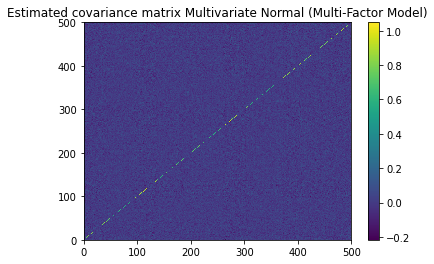

<Figure size 432x288 with 0 Axes>

In [11]:
# Correlation Matrix from Literature
plt.figure()
plt.pcolormesh(correlation_matrix)
plt.colorbar()
plt.title('Theoretical correlation matrix (Multi-Factor Model)')
plt.show()
plt.savefig('theoretical_covariance_multi_factor.png')
covar = np.cov(timeseries)

# True Covariance Matrix
plt.figure()
plt.pcolormesh(covar)
plt.colorbar()
plt.title('Covariance matrix (Multi-Factor Model)')
plt.show()
plt.savefig('true_covariance_multi_factor.png')

# sample returns from the covariance matrices
alphas_returns = np.random.multivariate_normal(np.zeros(N), cov=covar, size=500).T

plt.figure(figsize=(20, 10))
for i in range(N):
    plt.plot(range(500), alphas_returns.cumsum(axis=1)[i])
plt.title('Performance of the multivariate returns (Multi-Factor Model)', fontsize=24)
plt.show()
plt.savefig('cumul_multivariate_multi_factor.png')

# estimate the correlations and covariance
estimate_correl = np.corrcoef(alphas_returns)
estimate_covar = np.cov(alphas_returns)

plt.figure()
plt.pcolormesh(estimate_correl)
plt.colorbar()
plt.title('Estimated correlation matrix Multivariate Normal (Multi-Factor Model)')
plt.show()
plt.savefig('estim_cor_multivar_multi_factor.png')

plt.figure()
plt.pcolormesh(estimate_covar)
plt.colorbar()
plt.title('Estimated covariance matrix Multivariate Normal (Multi-Factor Model)')
plt.show()
plt.savefig('estim_cov_multivar_multi_factor.png')

### MST

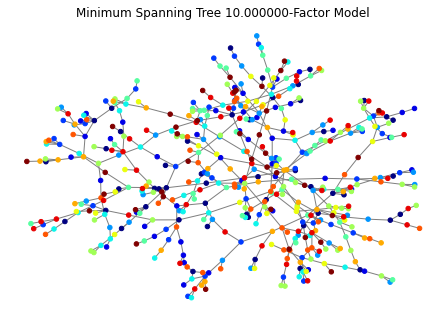

In [12]:
# Generate the distance matrix and MST
distance_matrix = correlation_to_distance(estimate_correl)
mst = generate_mst(distance_matrix)

# Plot the MST
plot_mst(mst, key)

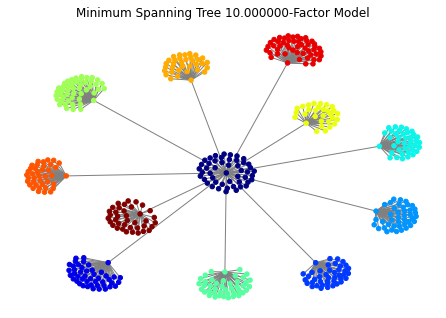

In [13]:
# Generate the distance matrix and MST
distance_matrix = correlation_to_distance(correlation_matrix)
mst = generate_mst(distance_matrix)

# Plot the MST
plot_mst(mst, key)

## Yelibi Hierarchical Levels within clusters - 'special' implementation of Tumminello technique 

### One Cluster, Five Hierarchies 

Generated beta values: [0.16666667 0.27777778 0.27777778 0.18518519 0.09259259]


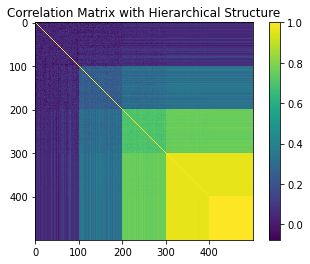

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def generate_beta_values(c, total_sum=1):
    """Generate beta values such that they are increasing and sum to total_sum"""
    beta_values = np.zeros(c)
    remaining = total_sum
    for i in range(c-1):
        beta_values[i] = remaining * (i+1) / (c + 1)  # Distribute an increasing proportion
        remaining -= beta_values[i]
    beta_values[-1] = remaining
    return beta_values

def hierarchical_factor_model(N, c, L):
    # Generate the hierarchical factors η
    eta = np.random.randn(c, L)
    
    # Generate ε - individual effects for each stock
    epsilon = np.random.randn(N, L)

    # Initialize the time series matrix for the stocks
    xi = np.zeros((N, L))

    # Generate beta values for the model
    beta_values = generate_beta_values(c)

    # Assigning stocks to hierarchies
    stocks_per_hierarchy = N // c

    for k in range(c):
        # Getting the range of stocks affected by this hierarchy
        start_idx = k * stocks_per_hierarchy
        end_idx = (k + 1) * stocks_per_hierarchy

        # Calculate the stock returns based on the hierarchy model
        alpha_k = 1 - np.sum(beta_values[:k+1])
        for j in range(k + 1):  # All factors up to this hierarchy
            xi[start_idx:end_idx, :] += beta_values[j] * eta[j, :]

        xi[start_idx:end_idx, :] += alpha_k * epsilon[start_idx:end_idx, :]

    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(xi)

    return xi, correlation_matrix, beta_values

# Parameters
N, c, L = 500, 5, 1000  # 500 stocks, 5 hierarchical factors, 1000 timesteps

# Run the hierarchical factor model
xi, correlation_matrix, beta_values = hierarchical_factor_model(N, c, L)

print("Generated beta values:", beta_values)

# Visualizing the correlation matrix
#plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.imshow(correlation_matrix, interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix with Hierarchical Structure')
plt.show()


### Three Clusters, Five Hierarchies 

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


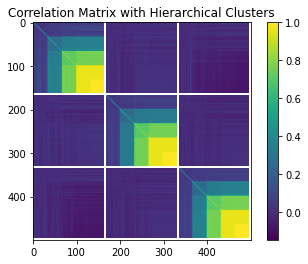

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def generate_beta_values(c, total_sum=1):
    """Generate beta values such that they are increasing and sum to total_sum"""
    beta_values = np.zeros(c)
    remaining = total_sum
    for i in range(c-1):
        beta_values[i] = remaining * (i+1) / (c + 1)  # Distribute an increasing proportion
        remaining -= beta_values[i]
    beta_values[-1] = remaining
    return beta_values

def hierarchical_factor_model(N, c, L, M):
    # Initialize the time series matrix for the stocks
    xi = np.zeros((N, L))

    # Overall stocks in each cluster
    stocks_per_cluster = N // M

    # Assigning stocks to clusters and then to hierarchies within clusters
    stocks_per_hierarchy = stocks_per_cluster // c
    
    for cluster in range(M):
        # Generate the hierarchical factors η for this cluster
        eta = np.random.randn(c, L)
        
        # Generate ε - individual effects for each stock in this cluster
        epsilon = np.random.randn(stocks_per_cluster, L)

        # Generate beta values for the model
        beta_values = generate_beta_values(c)
        
        for k in range(c):
            # Getting the range of stocks affected by this hierarchy
            start_idx = cluster * stocks_per_cluster + k * stocks_per_hierarchy
            end_idx = start_idx + stocks_per_hierarchy

            # Calculate the stock returns based on the hierarchy model
            alpha_k = 1 - np.sum(beta_values[:k+1])
            for j in range(k + 1):  # All factors up to this hierarchy
                xi[start_idx:end_idx, :] += beta_values[j] * eta[j, :]

            xi[start_idx:end_idx, :] += alpha_k * epsilon[(k * stocks_per_hierarchy):(k+1) * stocks_per_hierarchy, :]

    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(xi)

    return xi, correlation_matrix

# Parameters
N, c, L, M = 500, 5, 1000, 3  # 100 stocks, 5 hierarchical factors, 1000 timesteps, 3 clusters

# Run the hierarchical factor model
xi, correlation_matrix = hierarchical_factor_model(N, c, L, M)

# Visualizing the correlation matrix
plt.imshow(correlation_matrix)
plt.colorbar()
plt.title('Correlation Matrix with Hierarchical Clusters')
plt.show()


## Generating a Labeled Dataset

In [16]:
%pip install pathos

     |████████████████████████████████| 82 kB 854 kB/s eta 0:00:01
     |████████████████████████████████| 132 kB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 115 kB 13.7 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 10.8 MB/s eta 0:00:01
  Attempting uninstall: dill
    Found existing installation: dill 0.3.4
    Uninstalling dill-0.3.4:
      Successfully uninstalled dill-0.3.4
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.12.2
    Uninstalling multiprocess-0.70.12.2:
      Successfully uninstalled multiprocess-0.70.12.2
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pathos.multiprocessing import ProcessingPool as Pool
from multiprocessing import Pool, cpu_count

def sharpe_ratio(timeseries):
    """Calculate the Sharpe ratio for a given time series of returns."""
    mean_return = np.mean(timeseries)
    return_std = np.std(timeseries)
    return mean_return / return_std

def generate_and_classify(_):  # Dummy argument since map requires a function of one argument
    _, corr_matrix = hierarchical_factor_model(N, c, L, M)
    returns = np.random.multivariate_normal(np.zeros(N), corr_matrix, L)  # Monte Carlo using standard normal distribution
    portfolio_returns = np.mean(returns, axis=1)
    sr = sharpe_ratio(portfolio_returns)
    return (corr_matrix, 'bullish' if sr > 1 else 'bearish')

def parallel_spd_dataset_classification(n_samples):
    with Pool() as p:
        results = p.map(generate_and_classify, range(n_samples))
    return results

# Parameters
N, c, L, M = 500, 5, 1000, 3  # 500 stocks, 5 hierarchical factors, 1000 timesteps, 3 clusters
n_samples = 1000

# Generate the dataset and classify
dataset_with_labels = parallel_spd_dataset_classification(n_samples)

# Extracting matrices and labels separately
spd_dataset, labels = zip(*dataset_with_labels)

print(len(spd_dataset), labels.count('bullish'), labels.count('bearish'))


Process SpawnPoolWorker-6:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'generate_and_classify' on <module '__main__' (built-in)>
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = 

Process SpawnPoolWorker-15:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'generate_and_classify' on <module '__main__' (built-in)>
Process SpawnPoolWorker-16:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task 

Process SpawnPoolWorker-29:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'generate_and_classify' on <module '__main__' (built-in)>
Process SpawnPoolWorker-30:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task 

## Integrating Tumminello and Yelibi

In [ ]:
import numpy as np

def generate_beta_values(num_hierarchies):
    """ Generate beta values such that sum(beta) = 1 and beta[i] < beta[i+1] """
    betas = np.random.random(num_hierarchies)
    betas /= betas.sum()
    return np.sort(betas)

def hierarchical_nested_factor_model(N, L, num_clusters, num_hierarchies_per_cluster, num_factors, factor_weights=None):
    """ 
    Generate time series data and correlation matrix based on Hierarchical Nested Factor Model combined with multi-factor model.
    """
    # Generate factors
    factors = [np.random.randn(L) for _ in range(num_factors)]
    
    # Allocate each stock to a cluster
    stocks_in_clusters = N // num_clusters
    
    # If no factor weights provided, assume equal influence of each factor
    if factor_weights is None:
        factor_weights = np.ones(num_factors) / num_factors
    
    # Placeholder for time series and cluster membership
    time_series = np.zeros((N, L))
    cluster_membership = []
    
    for cluster in range(num_clusters):
        # Determine the hierarchical factors for this cluster
        betas = generate_beta_values(num_hierarchies_per_cluster)
        
        for stock in range(stocks_in_clusters):
            idx = cluster * stocks_in_clusters + stock
            
            # Each stock's return is influenced by the hierarchical factors and individual effect
            individual_effect = np.random.randn(L)
            
            # Aggregate influence from all factors
            for j, factor in enumerate(factors):
                alpha_j = 1 - sum([b**2 for b in betas[:j+1]])**0.5
                time_series[idx] += alpha_j * factor_weights[j] * factor
            
            # Add influence from hierarchical factors
            for h in range(num_hierarchies_per_cluster):
                eta = np.random.randn(L)
                time_series[idx] += betas[h] * eta
            
            # Add individual stock effect
            alpha = 1 - sum(b**2 for b in betas)**0.5
            time_series[idx] += alpha * individual_effect
            
            # Add this stock to the current cluster
            cluster_membership.append(cluster)
    
    # Compute correlation matrix
    correlation_matrix = np.corrcoef(time_series)
    
    return time_series, cluster_membership, correlation_matrix

# Example usage
N, L = 100, 1000
num_clusters = 5
num_hierarchies_per_cluster = 4
num_factors = 3

time_series, cluster_membership, correlation_matrix = hierarchical_nested_factor_model(N, L, num_clusters, num_hierarchies_per_cluster, num_factors)
